In [1]:
import torch as tn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import datetime
import torchtt as tntt
import tt_iga


tn.set_default_dtype(tn.float64)

In [2]:
R = 1.5
r = 1.0
H = 0.5
cov = 0.75
nl = 20
deg = 2
N = 64
delta_r = (R-r)/(2*nl+1)
n = 10

knots1 = [np.linspace(k/(2*nl+1),(k+1)/(2*nl+1) ,n) for k in range(2*nl+1)]

basis1 = tt_iga.bspline.BSplineBasis(np.concatenate(tuple(knots1)), deg)
basis2 = tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,(1-cov)/2,N//4), np.linspace((1-cov)/2,cov+(1-cov)/2,N//2), np.linspace(1-(1-cov)/2,1,N//4))) , deg)
basis3 = tt_iga.bspline.BSplineBasis(np.linspace(0,1,N), deg)
basis = [basis1, basis2, basis3]

xparam = lambda t: (r+(R-r)*t[...,0])*tn.cos(t[...,1]*np.pi/4)
yparam = lambda t: (r+(R-r)*t[...,0])*tn.sin(t[...,1]*np.pi/4)
zparam = lambda t: t[...,2]*H

geom = tt_iga.PatchBSpline.interpolate_geometry([xparam, yparam, zparam], basis, [])
N_basis = [b.N for b in geom.basis]


In [3]:
def material_alpha(y):
    delta_l = 1/(2*nl+1)
    return 0.0*y[...,2]+2.0*tn.logical_and(y[...,1]>=(1-cov)/2,y[:,1]<1-(1-cov)/2)*((tn.ceil(y[...,0]/delta_l)+1)%2)+1
    
tme = datetime.datetime.now() 
Mass_tt = geom.mass_interp(basis, eps=1e-11)
tme = datetime.datetime.now() -tme
print('Time mass matrix ',tme.total_seconds())

freq = 4
kinv = lambda y: (material_alpha(y)/(2*np.pi*freq))**2

tme = datetime.datetime.now() 
Stt = geom.stiffness_interp(basis, func=None, qtt = False, func_reference = kinv, verb=False)
tme = datetime.datetime.now() -tme
print('Time stiffness matrix ',tme.total_seconds())

Time mass matrix  0.183345
Time stiffness matrix  9.011334


In [4]:
Pin_tt,Pbd_tt = tt_iga.projectors.get_projectors(N_basis,[[0,0],[0,0],[0,0]])
# Pbd_tt = (1/N[0]) * Pbd_tt

Pin_tt = Pin_tt 
Pbd_tt = Pbd_tt 


f_tt = tntt.zeros(Stt.N)

excitation_dofs = tt_iga.Function(basis).interpolate(lambda t: tn.sin(t[:,0]*np.pi*2)*tn.sin(t[:,1]*np.pi))
tmp = tn.zeros(N_basis)
tmp[:,0,:] = excitation_dofs[:,:,0].full()
g_tt = Pbd_tt@tntt.TT(tmp)

eps_solver = 1e-7
M_tt = (Pin_tt@(Stt-Mass_tt)+Pbd_tt).round(1e-12)
rhs_tt = (Pbd_tt @ g_tt).round(1e-12)

M_tt = M_tt.round(1e-11)

In [5]:


# M_qtt = ttm2qttm(M_tt).round(1e-9)
# rhs_qtt = tt2qtt(rhs_tt)
cuda = False
print('Solving in TT...')
tme_amen = datetime.datetime.now() 
if cuda and tn.cuda.is_available():
    dev = 'cuda:1'
    dofs_tt = tntt.solvers.amen_solve(M_tt.to(dev), rhs_tt.to(dev), x0 = tntt.ones(rhs_tt.N).to(dev), eps = eps_solver, nswp=40, kickrank=4, verbose=True, preconditioner = 'c', local_iterations=24, resets=10).cpu()
else:
    dofs_tt = tntt.solvers.amen_solve(M_tt, rhs_tt, x0 = tntt.ones(rhs_tt.N), eps = eps_solver, nswp=40, kickrank=4, verbose=True, preconditioner = 'c')
tme_amen = (datetime.datetime.now() -tme_amen).total_seconds() 

print('',flush=True)
print('Time system solve in TT ',tme_amen)
print('Relative residual ', (M_tt@dofs_tt-rhs_tt).norm()/rhs_tt.norm())




Solving in TT...

Starting sweep 0 ...
	Core 0
		Choosing direct solver (local size 411)....
		dx = 11.7671, res_now = 1.38407e-16, res_old = 17.8885
	Core 1
		Choosing direct solver (local size 325)....
		dx = 2.16393, res_now = 1.40408e-22, res_old = 0.79055
	Core 2
		Choosing direct solver (local size 325)....
		dx = 0.765068, res_now = 2.61281e-16, res_old = 0.575147
Solution rank is [1, 5, 5, 1]
Maxres  tensor(17.8885)
Time  0:00:00.031461

Starting sweep 1 ...
	Core 0
		Choosing iterative solver GMRES (local size 2055)....
		Finished with flag 0 after 80 iterations with relres 1.90482e-07 (from 0.00537356)
		Time needed  0:00:00.253067
		dx = 0.331851, res_now = 1.90482e-07, res_old = 5.37214e-06
	Core 1
		Choosing iterative solver GMRES (local size 2925)....
		Finished with flag 1 after 24 iterations with relres 2.77504e-08 (from 0.00208062)
		Time needed  0:00:00.045978
		dx = 0.994707, res_now = 2.77504e-08, res_old = 1.38745e-05
	Core 2
		Choosing iterative solver GMRES (loca

In [6]:
print('N ',dofs_tt.N)
print('Rank Mtt ',M_tt.R)
print('Rank rhstt ',rhs_tt.R)
print('Rank solution ',dofs_tt.round(1e-10).R)
print('size stiff ',tntt.numel(Stt)*8/1e6,' MB')
print('size mass ',tntt.numel(Mass_tt)*8/1e6,' MB')
print('size system mat ',tntt.numel(M_tt)*8/1e6,' MB')
print('size rhstt ',tntt.numel(rhs_tt)*8/1e6,' MB')
print('size solution ',tntt.numel(dofs_tt)*8/1e6,' MB, one full solution: ',np.prod(dofs_tt.N)*8/1e6,' MB')

N  [411, 65, 65]
Rank Mtt  [1, 8, 4, 1]
Rank rhstt  [1, 1, 1, 1]
Rank solution  [1, 57, 48, 1]
size stiff  11.419344  MB
size mass  1.418968  MB
size system mat  12.027744  MB
size rhstt  0.004328  MB
size solution  1.906536  MB, one full solution:  13.8918  MB


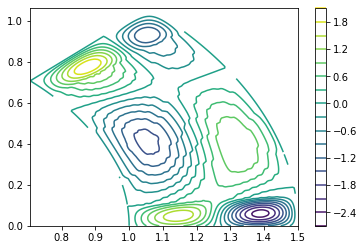

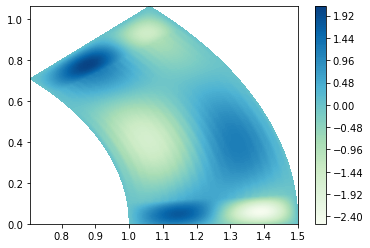

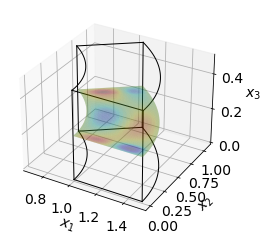

In [7]:




fspace = tt_iga.Function(basis)
fspace.dofs = dofs_tt

fval = fspace([tn.linspace(0,1,128),tn.linspace(0,1,128),tn.tensor([0.5])])
x,y,z =  geom([tn.linspace(0,1,128),tn.linspace(0,1,128),tn.tensor([0.5])])

plt.figure()
plt.contour(x.numpy().squeeze(),y.numpy().squeeze(),fval.numpy().squeeze(), levels = 16)
plt.colorbar()

plt.figure()
plt.contourf(x.numpy().squeeze(),y.numpy().squeeze(),fval.numpy().squeeze(), levels = 128, cmap = 'GnBu')
plt.colorbar()


fig = geom.plot_domain(None,[(0,1),(0,1),(0.0,1)],surface_color=None, wireframe = False,frame_color='k',n = 64)

ax = fig.gca()
C = fval.numpy().squeeze()
norm = matplotlib.colors.Normalize(vmin=C.min(),vmax=C.max())
C = plt.cm.jet(norm(C))
C[:,:,-1] = 1
ax.plot_surface(x.numpy().squeeze(), y.numpy().squeeze(), z.numpy().squeeze(), edgecolors=None, linewidth=0, facecolors = C, antialiased=True, rcount=256, ccount=256, alpha=0.5)
fig.gca().set_xlabel(r'$x_1$', fontsize=14)
fig.gca().set_ylabel(r'$x_2$', fontsize=14)
fig.gca().set_zlabel(r'$x_3$', fontsize=14)
fig.gca().zaxis.set_rotate_label(False)
fig.gca().tick_params(axis='both', labelsize=14)

# plt.savefig('./data/wg_solution.pdf')
